# Example of how to fit spectra using species 

This tutorial goes through all the individual steps of ```fitspec``` outside of the class structure.  We will use a NIR spectra (0.9-2.5μm) from SOAR/TripleSpec of the brown dwarf 2MASS J11011926-7732383. The data are currently published in Betti (2023) https://ui.adsabs.harvard.edu/abs/2023PhDT........13B/abstract 



## Getting started

First download and install ```species``` from https://species.readthedocs.io/en/latest/installation.html if you do not have it downloaded.  You must also have ```pymultinest``` installed: https://johannesbuchner.github.io/PyMultiNest/install.html#building-the-libraries

Now import Python modules.  You should set your ```DYLD_LIBRARY_PATH``` following the ```species``` installation instructions.

In [1]:
import warnings
# warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
os.environ['DYLD_LIBRARY_PATH'] = '/Users/sbetti/data/MultiNest/lib'

from species import SpeciesInit
from species.data.database import Database
from species.fit.fit_model import FitModel
from species.read.read_model import ReadModel
from species.plot.plot_mcmc import plot_posterior
from species.plot.plot_spectrum import plot_spectrum
from species.util.box_util import update_objectbox
from species.util.fit_util import get_residuals, multi_photometry
from species.fit.compare_spectra import CompareSpectra
from species.plot.plot_comparison import plot_empirical_spectra

import corner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from astropy import constants
from astropy.io import fits
from astropy import units as u

from scipy.stats import binned_statistic
from specutils import Spectrum1D


/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/fit/fit_model.py:18: UserWarning: UltraNest could not be imported. Perhaps because cython was not correctly compiled?
  warnings.warn(


Determine the path to your spectra and the object name.  The spectra can be in any format because we are going to re-save it in a simple ```.dat``` file.

In [2]:
DATADIR =  '/Users/sbetti/Documents/Science/datasets/TSpec/final_data/2MASS J11011926-7732383.fits'
OBJ_NAME = '2MASS_J11011926-7732383'

Here, we read the FITS file with ```astropy```.  For simplicity, we bin our data to R~500 and extract the full spectra and the spectra up to 1.9μm.  We only want the real values for fitting (no ```NaN```s or ```INF```s)

The data needs to be saved in the format ```{OBJ_NAME}_R{resolution}_short.dat``` (optional) for a sliced spectra and ```{OBJ_NAME}_R{resolution}_full.dat``` (required) for the full spectra.

In [3]:
a = fits.getdata(DATADIR)
wave = a[0]
flux = a[1]
noise = a[2]

binwave = np.arange(wave.min(), wave.max(), 0.005)
FLUX = binned_statistic(wave, flux, statistic='mean', bins=binwave)[0]
NOISE = binned_statistic(wave, flux, statistic='std', bins=binwave)[0]
WAVE = binwave[0:-1]
# only extract real values
idx = np.where(np.isfinite(FLUX))
idx2 = np.where(np.isfinite(FLUX) & (WAVE < 1.9))
np.savetxt(f'{OBJ_NAME}_R500_short.dat', np.c_[WAVE[idx2], FLUX[idx2], NOISE[idx2]])
np.savetxt(f'{OBJ_NAME}_R500_full.dat', np.c_[WAVE[idx], FLUX[idx], NOISE[idx]])

 ############################## Xspextool History ############################## [astropy.io.fits.card]
 ############################## Xcombspec History ############################## [astropy.io.fits.card]
 ############################### Xtellcor History ############################## [astropy.io.fits.card]
 ############################# Xmergeorders History ############################ [astropy.io.fits.card]


We now determine the parallax.  This is necessary for proper fitting of the object radius. We show a couple of different ways to get this value:
1. using astroquery.simbad
2. using CASPAR (Betti+2023) 
     - CASPAR (Comprehensive Archive of Substelalr and Planetary Accretion Rates) is an archive of accretion and stellar properties for accreting objects.
     
Method using simbad

In [4]:
from astroquery.simbad import Simbad
simbad = Simbad()
simbad.add_votable_fields("parallax")
# the name should be simbad resolvable! 
simbad_name = '2MASS J11011926-7732383'
result_table = simbad.query_object(simbad_name)

PARALLAX = result_table['PLX_VALUE'][0]
PARALLAX_err = result_table['PLX_ERROR'][0]
print(PARALLAX, PARALLAX_err)
result_table[['MAIN_ID', 'PLX_VALUE', 'PLX_ERROR']]

-- --


MAIN_ID,PLX_VALUE,PLX_ERROR
,mas,mas
object,float64,float32
2MASS J11011926-7732383,--,--


Method using CASPAR.  
first download the CASPAR google sheet if you do not already have it. 

In [5]:
import gdown
url = 'https://drive.google.com/uc?id=1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs'
output = "caspar.xlsx"
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs
From (redirected): https://docs.google.com/spreadsheets/d/1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs/export?format=xlsx
To: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example/caspar.xlsx
3.99MB [00:00, 14.6MB/s]


'caspar.xlsx'

In [6]:
caspar = pd.read_excel('caspar.xlsx', sheet_name='Literature Database', skiprows=[1])
caspar['Mass jup'] = (np.array(caspar['Mass'].values)*u.Msun).to(u.Mjup).value
caspar['Radius jup'] = (np.array(caspar['Radius'].values)*u.Rsun).to(u.Rjup).value
caspar_obj = caspar.loc[caspar['Reference Name']==simbad_name]

PARALLAX = caspar_obj['GAIA EDR3 Parallax'].values[0]
PARALLAX_err = caspar_obj['GAIA EDR3 Parallax err'].values[0]
print(PARALLAX, PARALLAX_err)
caspar_obj[['Reference Name','GAIA EDR3 Parallax', 'GAIA EDR3 Parallax err', 'A_V', 'Teff', 'Mass','Mass jup', 'Radius jup']]


5.3603 0.149


,Reference Name,GAIA EDR3 Parallax,GAIA EDR3 Parallax err,A_V,Teff,Mass,Mass jup,Radius jup
204,2MASS J11011926-7732383,5.3603,0.149,1.59,2838.0,0.05,52.378276,5.741384


In [7]:
## if neither method gives a parallax, add them in manually
# PARALLAX = 
# PARALLAX_err = 

## Start our Fitting

We are going to use our R~500 spectra and find the best fit parameters that describe our spectra.  We first add the object to our ```species``` database.  

Note that the spectral resolution MUST be a float (e.g. ```500.```).  And integer will cause ```species``` to fail. 

We add in our spectra.  You can include both the shorted and long or one of the other.  The key in the spectrum dictionary helps differentiate them below.  

We also add in our empirical libraries; we add ```bonnefoy+2014``` and ```spex``` from the ```species``` options. We add both the M and L dwarfs as well. 

In [8]:
SpeciesInit()
database = Database()

# MUST HAVE PERIOD!
spec_res = 500.

database.add_object(OBJ_NAME,
                    parallax=(PARALLAX, PARALLAX_err),
                    app_mag=None,
                    flux_density=None,
                    spectrum={'SOAR': (f'{OBJ_NAME}_R{int(spec_res)}_short.dat', None, spec_res),
                              'SOARfull': (f'{OBJ_NAME}_R{int(spec_res)}_full.dat', None, spec_res),},
                    deredden=None)

database.add_spectra(spec_library='bonnefoy+2014', sptypes=['M', 'L'])
database.add_spectra(spec_library='spex', sptypes=['M', 'L'])

species

Version: 0.9.1.dev71+g96da3de.d20250528
Working folder: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example

Configuration file: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example/species_config.ini
Database file: species_database.hdf5
Data folder: data

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed

----------
Add object
----------

Object name: 2MASS_J11011926-7732383
Units: None
Deredden: None
Parallax (mas) = 5.36 +/- 0.15

Spectra:
   - Spectrum:
      - Database tag: SOAR
      - Filename: 2MASS_J11011926-7732383_R500_short.dat
      - Data shape: (157, 3)
      - Wavelength range (um): 0.95 - 1.81
      - Mean flux (W m-2 um-1): 6.43e-15
      - Mean error (W m-2 um-1): 2.37e-16
   - Spectrum:
      - Database tag: SOARfull
      - Filename: 2MASS_J11011926-7732383_R500_full.dat
      - Data shape: (264, 3)
      - Wavelength range (um): 0

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/phot/syn_phot.py:88: UserWarning: Please note that a manually provided zero-point flux is by default equalized to a magnitude of 0.03 for all filters. The magnitude of Vega can be adjusted in the configuration file (see https://species.readthedocs.io/en/latest/configuration.html) by setting the 'vega_mag' parameter. Currently the parameter is set to 0.03.
  warnings.warn(


Adding spectra... 2MASS J05103520-4208140 

Adding spectra... 2MASS J12121714-2253451

Adding spectra... 2MASS J14171672-0407311

Adding spectra... SDSS J035104.37+481046.8    

Adding spectra... [DONE]                    


First, we set up our class to compare our spectra.  We chose which spectrum to compare to using ```spec_name```.  

In [9]:

compare = CompareSpectra(object_name=OBJ_NAME,
                         spec_name=['SOARfull'])


Then, we find the best fit empirical template from spex and Bonnefoy+2014 for our spectra.  We chose the library (e.g. ```spec``` or ```bonnefoy+2014```) from the list of available ```species``` libraries.  We can adjust the ```wavel_range``` for the comparison.  We can also select which spectral types we want to look through, the range of Av to test against.  Note, that the label position ```label_pos``` refers to the position of the bottom most label in the figure. 

Processing spectra... [DONE]                      
Best-fitting spectra:
    1. G = 8.82e+01 -> 2MASS J11395113-3159214, M9, A_V = 0.80, RV = 0 km/s,
                       scalings = [0.37190031]
    2. G = 9.66e+01 -> MHO 4, M7, A_V = 2.70, RV = 0 km/s,
                       scalings = [0.19089638]
    3. G = 9.76e+01 -> 2MASS J04414825+2534304, M7, A_V = 2.20, RV = 0 km/s,
                       scalings = [0.9821969]
    4. G = 1.12e+02 -> CFHT 6, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [0.42097684]
    5. G = 1.13e+02 -> KPNO 5, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [0.45182679]
    6. G = 1.14e+02 -> KPNO 2, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [1.53406654]
    7. G = 1.19e+02 -> CFHT 3, M7, A_V = 2.10, RV = 0 km/s,
                       scalings = [1.01793968]
    8. G = 1.31e+02 -> SO 0253+1625, M7, A_V = 2.70, RV = 0 km/s,
                       scalings = [0.01150361]
    9. G = 1.32e+02 -> 2MASS J044

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/plot/plot_comparison.py:453: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output

 [DONE]


/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


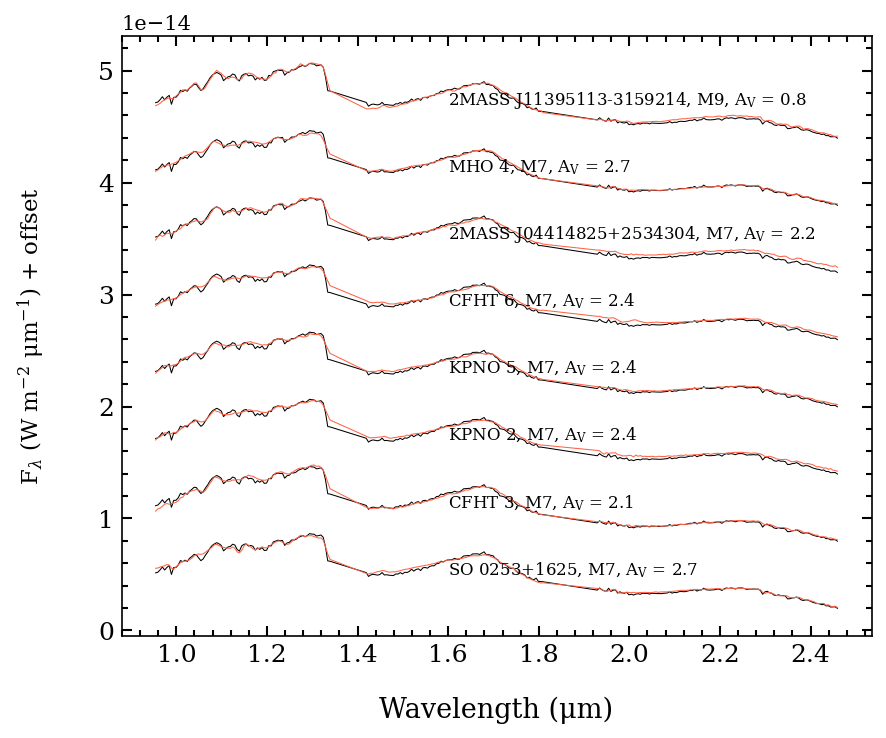

In [10]:

compare.spectral_type(tag=OBJ_NAME,
                     spec_library='spex',
                     wavel_range=(0.9,1.9),
                     sptypes=['M'], 
                     av_ext=np.arange(0,5, 0.1), )

fig = plot_empirical_spectra(tag=OBJ_NAME,
                         n_spectra=8,
                         flux_offset=6e-15,
                         label_pos=(1.6, 5e-15),
                         xlim=None,
                         ylim=None,
                         title=None,
                         offset=None,
                         figsize=(5,4),
                         output=f'{OBJ_NAME}_spex_comparison')

Processing spectra... [DONE]    
Best-fitting spectra:
    1. G = 1.64e+03 -> 2M1207A, M8, A_V = 2.10, RV = 0 km/s,
                       scalings = [67969374.41982022]
    2. G = 2.01e+03 -> USco 108 B, M7, A_V = 0.70, RV = 0 km/s,
                       scalings = [1.20445913e+09]
    3. G = 2.04e+03 -> DH Tau B, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [4.95424589e+08]
    4. G = 3.09e+03 -> OTS 44, M9.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [8.55714554e+08]
    5. G = 3.40e+03 -> KPNO Tau 4, M9.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [2.30476203e+08]
    6. G = 5.49e+03 -> Cha1109, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [2.07411869e+09]
    7. G = 1.05e+04 -> TWA 5B, M8.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [7.00770274e-15]
    8. G = 1.13e+04 -> CT Cha b, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [6.95157441e-15]
    9. G = 3.05e+04 -> HR7329B, M7

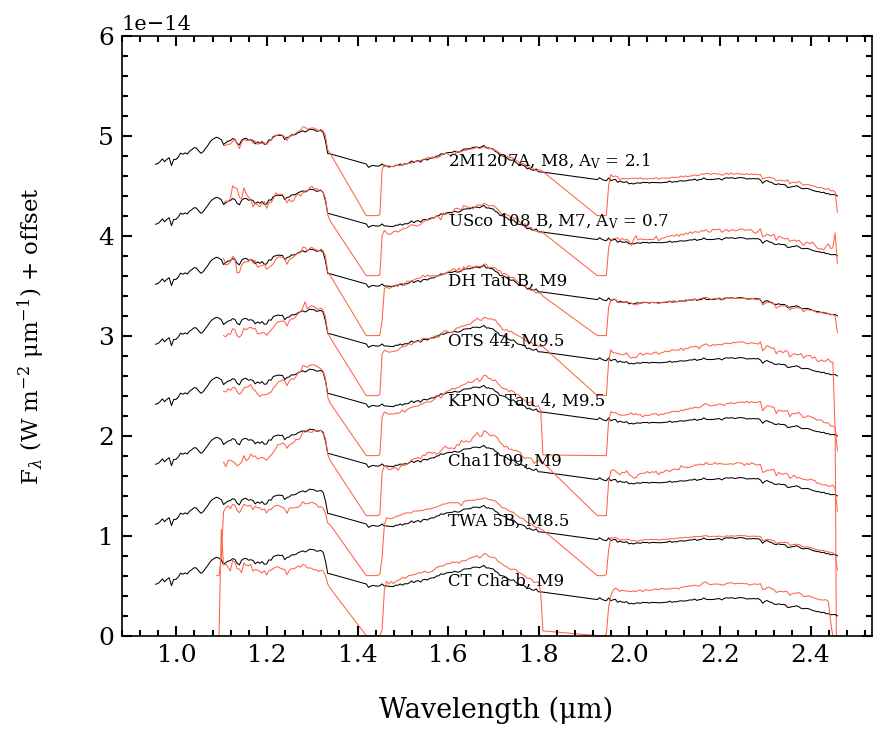

In [11]:

compare.spectral_type(tag=OBJ_NAME,
                     spec_library='bonnefoy+2014',
                     wavel_range=(0.9, 1.9),
                     sptypes=['M'], 
                     av_ext=np.arange(0,5, 0.1), )

fig = plot_empirical_spectra(tag=OBJ_NAME,
                         n_spectra=8,
                         flux_offset=6e-15,
                         label_pos=(1.6, 5e-15),
                         xlim=None,
                         ylim=(0, 6e-14),
                         title=None,
                         offset=None,
                         figsize=(5,4),
                         output=f'{OBJ_NAME}_bonnefoy_comparison')


### Spectral Model Grid search

Next, we find the best fit theoretical model for our spectra using a grid search.  We can chose which model to look at from the ```species``` package, and the ```wavel_range``` to compare to.  We can also select which temperature range we want to look through, the range of Av to test against, and if we are fixing the log g.  The label position refers to the position of the bottom most label in the figure. 


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 23/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.9 - 1.9
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2500.0 - 2800.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_2800_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2500. 2600. 2700. 2800.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 4
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 24
Number of interpolated grid points: 1
Number of missing grid points: 0
Processing model spectrum 79/200...

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/util/data_util.py:413: RuntimeWarning: divide by zero encountered in log10
  flux = np.log10(flux)
/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/fit/compare_spectra.py:617: UserWarning: The extracted model spectrum contains 107 fluxes with NaN. Probably because some of the wavelengths of the data are outside the available wavelength range of the model grid. These wavelengths are ignored when calculating the goodness-of-fit statistic.
  warnings.warn(


Processing model spectrum 200/200... [DONE]
Best-fit parameters:
   - Goodness-of-fit = 1.03e+02
   - teff = 2700.0
   - logg = 4.0
   - ism_ext = 2.3000000000000003
   - Radius (Rjup) = 6.09
   - Scaling = 5.72e-21
Plotting model spectra comparison: 2MASS_J11011926-7732383_btsettlcifistgrid_comparison...
Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range 

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/plot/plot_comparison.py:1302: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output, bbox_inches="tight")


 [DONE]


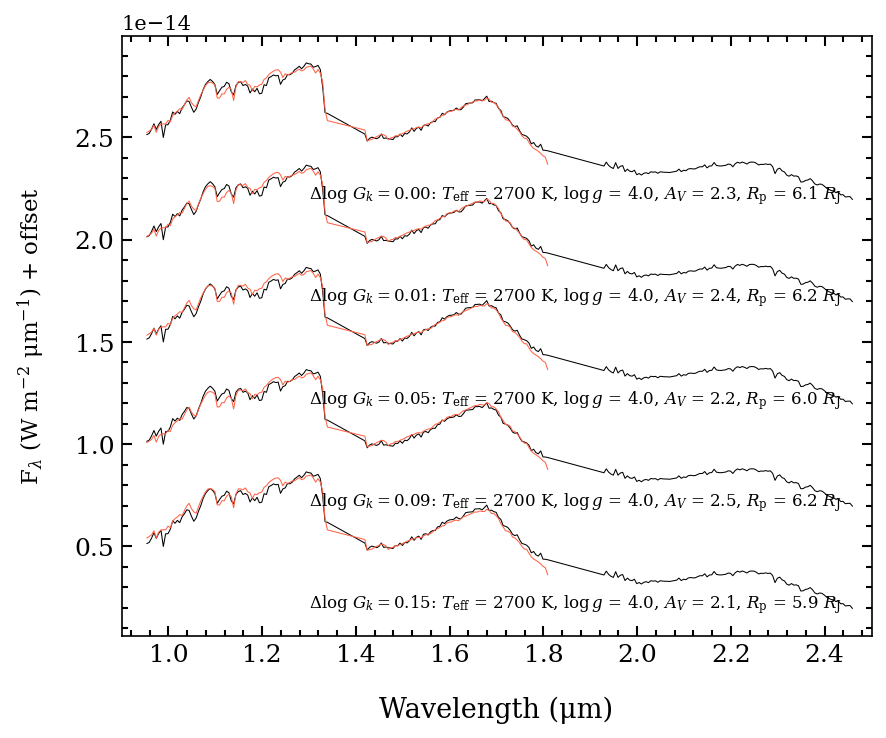

In [12]:
database.add_model(model='bt-settl-cifist', teff_range=(2500., 2800.), 
                  wavel_range=(0.9, 1.9))

compare.compare_model(tag=OBJ_NAME,
                      model='bt-settl-cifist',
                      av_points=np.arange(0,5, 0.1),
                      fix_logg=4.0,
                      scale_spec=None,
                      weights=False,
                      inc_phot=False)
                      

from species.plot.plot_comparison import plot_model_spectra
fig = plot_model_spectra(tag=OBJ_NAME,
                         n_spectra=5,
                         flux_offset=5e-15,
                         label_pos=(1.3, 2e-15),
                         xlim=(0.9, 2.5),
                         ylim=None,
                         title=None,
                         offset=None,
                         figsize=(5,4),
                         output=f'{OBJ_NAME}_btsettlcifistgrid_comparison',
                         leg_param=['teff', 'logg', 'ism_ext', 'radius'])

---

## Model fitting using multinest MCMC

Now we get to the main portion -- the mcmc fitting to the theoretical spectra.  Here, we are using ```species``` multinest fitting.  

We first determine our model library we want, the spectral resolution, and the temperature range of models to add.  The ```teff_range``` is the range of temperature range of models and must be equal to or larger than the bounds ```teff``` below.

In [13]:
SpeciesInit()
database = Database()

# MUST HAVE PERIOD!
model = 'bt-settl-cifist'
spec_res = 500.
# spec_res = 2700.

database.add_model(model=model, teff_range=(2500., 3600.))

species

Version: 0.9.1.dev71+g96da3de.d20250528
Working folder: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example

Configuration file: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example/species_config.ini
Database file: species_database.hdf5
Data folder: data

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed

-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 71/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2500.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500. 3600.]
   - log(g) = 

Next, we set up our model paramters to fit.  We determine the free paramters and bounds (see ```species``` for which parameters are available.  By using the same value for the beginning and end, the value is held constant.  We again pick which spectra to fit (we chose the short JH one as we do not want any excess emission at 2.4 μm to affect the Av estimate.)  


In [14]:
fit = FitModel(object_name=OBJ_NAME,
               model=model,
               bounds={'teff': (2500,3200),
                       'radius': (1, 15),
                       'ext_av':(0,5),
                      'logg':(4.0, 4.0)},
               inc_phot=False,
               inc_spec=['SOAR'],
               fit_corr=None,
               apply_weights=False, ext_model='CCM89') 



-----------------
Fit model spectra
-----------------

Object name: 2MASS_J11011926-7732383
Model tag: bt-settl-cifist
Binary star: False
Blackbody components: 0
Teff interpolation range: (2500, 3200)

Interpolating SOAR... [DONE]

Fixing 1 parameters:
   - logg = 4.0

Fitting 4 parameters:
   - teff
   - radius
   - parallax
   - ext_av

Uniform priors (min, max):
   - teff = (2500, 3200)
   - radius = (1, 15)
   - ext_av = (0, 5)

Normal priors (mean, sigma):
   - parallax = 5.36 +/- 0.15

Weights for the log-likelihood function:
   - SOAR = 1.00


Now, we run the MCMC!  The more ```n_live_points``` chosen, the better the fit.  We estimate ~2000 is good for a well populated parameter space.  

In [15]:
fit.run_multinest(tag=OBJ_NAME,
                  n_live_points=100,
                  resume=False,
                  output='multinest/',
                  kwargs_multinest=None)


------------------------------
Nested sampling with MultiNest
------------------------------

Database tag: 2MASS_J11011926-7732383
Number of live points: 100
Resume previous fit: False
Output folder: multinest/

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  100
 dimensionality =    4
 *****************************************************
 ln(ev)=   5461.5709704156534      +/-  0.33655669874737415     
 Total Likelihood Evaluations:         4572
 Sampling finished. Exiting MultiNest

log-evidence = 5461.57 +/- 0.34
log-evidence (importance sampling) = 5460.07 +/- 0.11

Sample with the maximum likelihood:
   - Log-likelihood = 5474.45
   - teff = 2679.30
   - radius = 6.17
   - parallax = 5.37
   - ext_av = 2.32

---------------------
Add posterior samples
---------------------

Database tag: 2MASS_J11011926-7732383
Sampler: multinest
Samples shape: (413, 5)
ln(Z) = 5461.57 +/- 0.3

After fitting, we can plot the posterior


---------------------
Get posterior samples
---------------------

Database tag: 2MASS_J11011926-7732383
Random samples: None
Samples shape: (413, 5)

Parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Uniform priors (min, max):
   - ext_av = (0, 5)
   - radius = (1, 15)
   - teff = (2500, 3200)

Normal priors (mean, sigma):
   - parallax = (5.36, 0.15)

----------------------------
Plot posterior distributions
----------------------------

Database tag: 2MASS_J11011926-7732383
Object type: planet
Manual parameters: None

Model type: atmosphere
Model name: bt-settl-cifist
Sampler: multinest

Median parameters:
   - teff = 2681.19
   - radius = 6.17
   - parallax = 5.36
   - ext_av = 2.32
   - logg = 4.00

Sample with the maximum likelihood:
   - teff = 2679.30
   - radius = 6.17
   - parallax = 5.37
   - ext_av = 2.32
   - logg = 4.00

Parameters included in corner plot:
   - teff
   - radius
   - parallax
   - ext_av
   - logg
   - log_lum_atm


/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(



Output: 2MASS_J11011926-7732383_mcmc_posterior


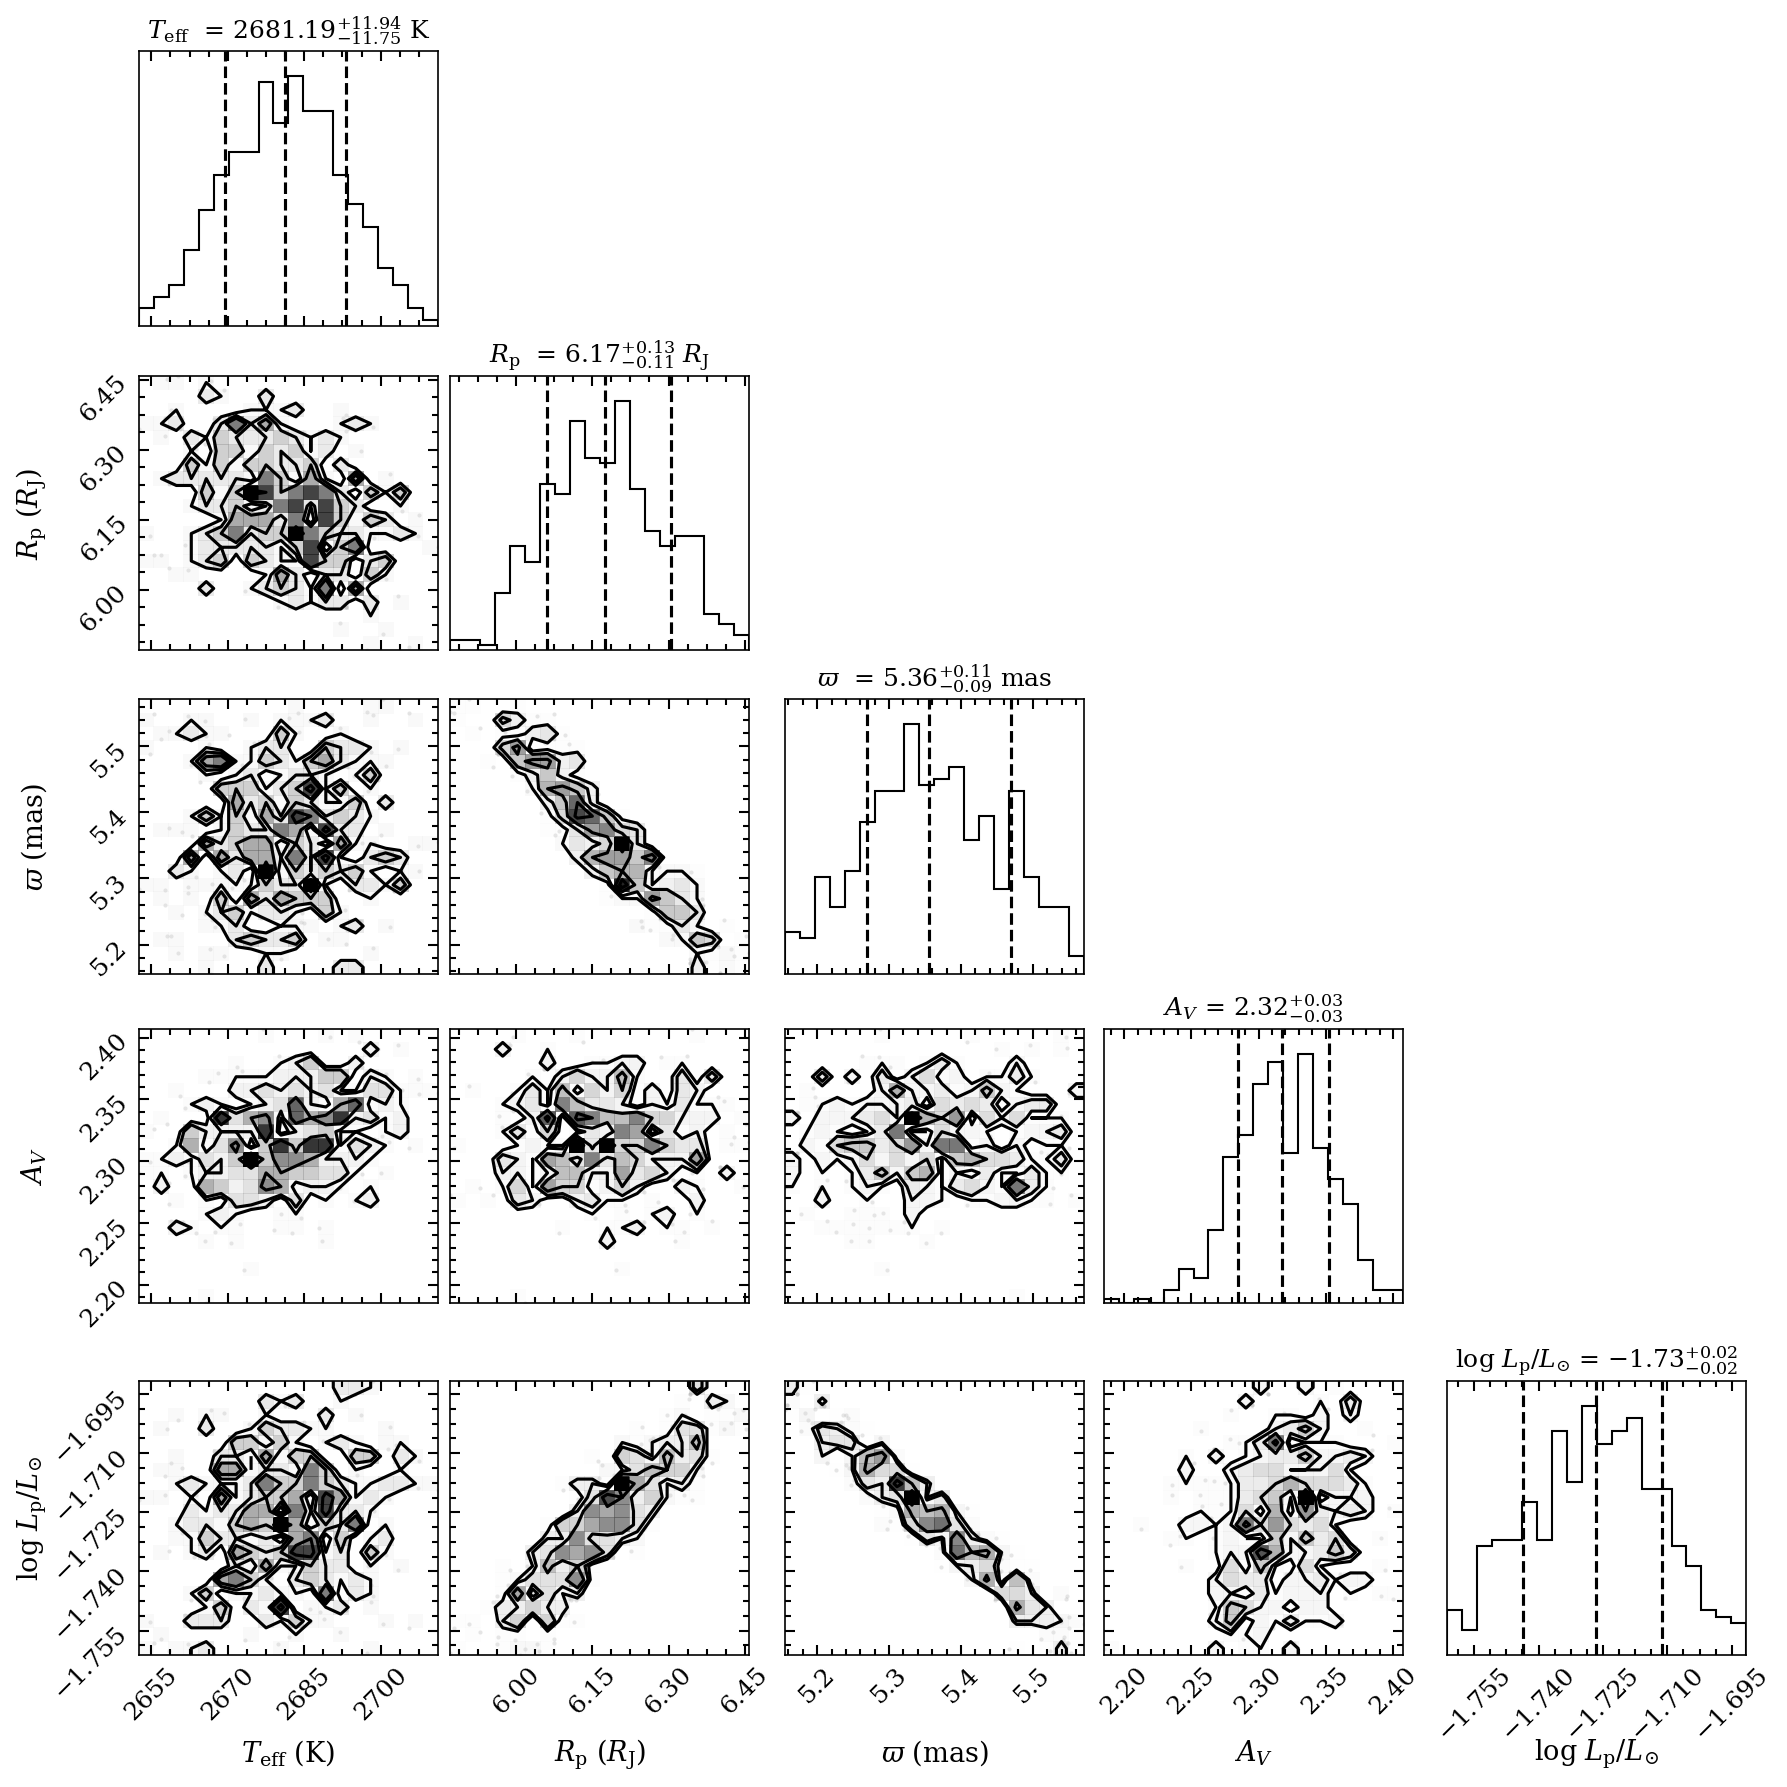

In [16]:
fig = plot_posterior(tag=OBJ_NAME,
                     offset=(-0.3 , -0.3),
                     title_fmt='.2f',
                     inc_luminosity=True,
                     inc_mass=False,
                     output=f'{OBJ_NAME}_mcmc_posterior')

Next, we pull out all the posterior samples, the best fit samples (and luminosity), the best fit paramters, and the best fit spectra and residuals.

In [17]:
box_plotting = database.get_samples(tag=OBJ_NAME)
samples_plotting = box_plotting.samples
params_plotting = box_plotting.parameters

teff_index = np.argwhere(np.array(params_plotting) == "teff")[0]
radius_index = np.argwhere(np.array(params_plotting) == "radius")[0]
R_JUP = constants.R_jup.value
L_SUN = constants.L_sun.value
SIGMA_SB = constants.sigma_sb.value
lum_atm_plotting = (4.0 * np.pi * (samples_plotting[..., radius_index] * R_JUP) ** 2 * SIGMA_SB * samples_plotting[..., teff_index] ** 4.0 / L_SUN)

samples_plotting = samples_plotting[:, 0:4]
params_plotting = params_plotting[0:4]
ndim_plotting = len(params_plotting)

samples_plotting = np.append(samples_plotting, np.log10(lum_atm_plotting), axis=-1)
params_plotting.append("log_lum_atm")
ndim_plotting += 1
best_samples = samples_plotting.reshape((-1, ndim_plotting))


---------------------
Get posterior samples
---------------------

Database tag: 2MASS_J11011926-7732383
Random samples: None
Samples shape: (413, 5)

Parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Uniform priors (min, max):
   - ext_av = (0, 5)
   - radius = (1, 15)
   - teff = (2500, 3200)

Normal priors (mean, sigma):
   - parallax = (5.36, 0.15)


In [18]:
samples = database.get_mcmc_spectra(tag=OBJ_NAME,
                                    random=30,
                                    wavel_range=None,
                                    spec_res=spec_res)

best = database.get_median_sample(tag=OBJ_NAME)
read_model = ReadModel(model=model, wavel_range=None)
modelbox = read_model.get_model(model_param=best,
                                spec_res=spec_res)
objectbox = database.get_object(object_name=OBJ_NAME,
                                inc_phot=False,
                                inc_spec=['SOARfull'])
objectbox = update_objectbox(objectbox=objectbox, model_param=best)
residuals = get_residuals(tag = OBJ_NAME,
                          parameters=best,
                          objectbox=objectbox,
                          inc_phot=False,
                          inc_spec=True)


---------------------
Get posterior spectra
---------------------

Database tag: 2MASS_J11011926-7732383
Wavelength range (um): None
Resolution: 500.0
Number of samples: 30



  0%|          | 0/30 [00:00<?, ?it/s]

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/read/read_model.py:963: UserWarning: The wavelength range of the model spectrum (0.100-5000.000 um) does not fully lie within the available wavelength range of the extinction model (0.100-3.333 um). The extinction will therefore not be applied to fluxes of which the wavelength lies outside the range of the extinction model.
  warnings.warn(



---------------------
Get median parameters
---------------------

Database tag: 2MASS_J11011926-7732383

Parameters:
   - teff = 2681.19
   - radius = 6.17
   - parallax = 5.36
   - ext_av = 2.32
   - logg = 4.00

----------
Get object
----------

Object name: 2MASS_J11011926-7732383
Include photometry: False
Include spectra: ['SOARfull']

----------------
Update ObjectBox
----------------


-------------------
Calculate residuals
-------------------

Database tag: 2MASS_J11011926-7732383
Results type: FitModel
Model: bt-settl-cifist
Binary: False

Model parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Fixed parameters:
   - logg

Include photometry: False
Include spectra: True

Residuals (sigma):
   - SOARfull: min = -2.14, max = 3.43

Number of data points = 264
Number of model parameters = 5
Number of fixed parameters = 1
Number of degrees of freedom = 260

chi2 = 259.64
reduced chi2 = 1.00


Now we can plot the best fit model with residuals as well as a nicer "publication" version. We use the full length spectra for the plotting.


-------------
Plot spectrum
-------------

Boxes:
   - List with 30 x ModelBox
   - ModelBox
   - ObjectBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (8.0, 4.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}

Output: 2MASS_J11011926-7732383_mcmc_bestfit


/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/plot/plot_spectrum.py:1563: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output, bbox_inches="tight")
/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


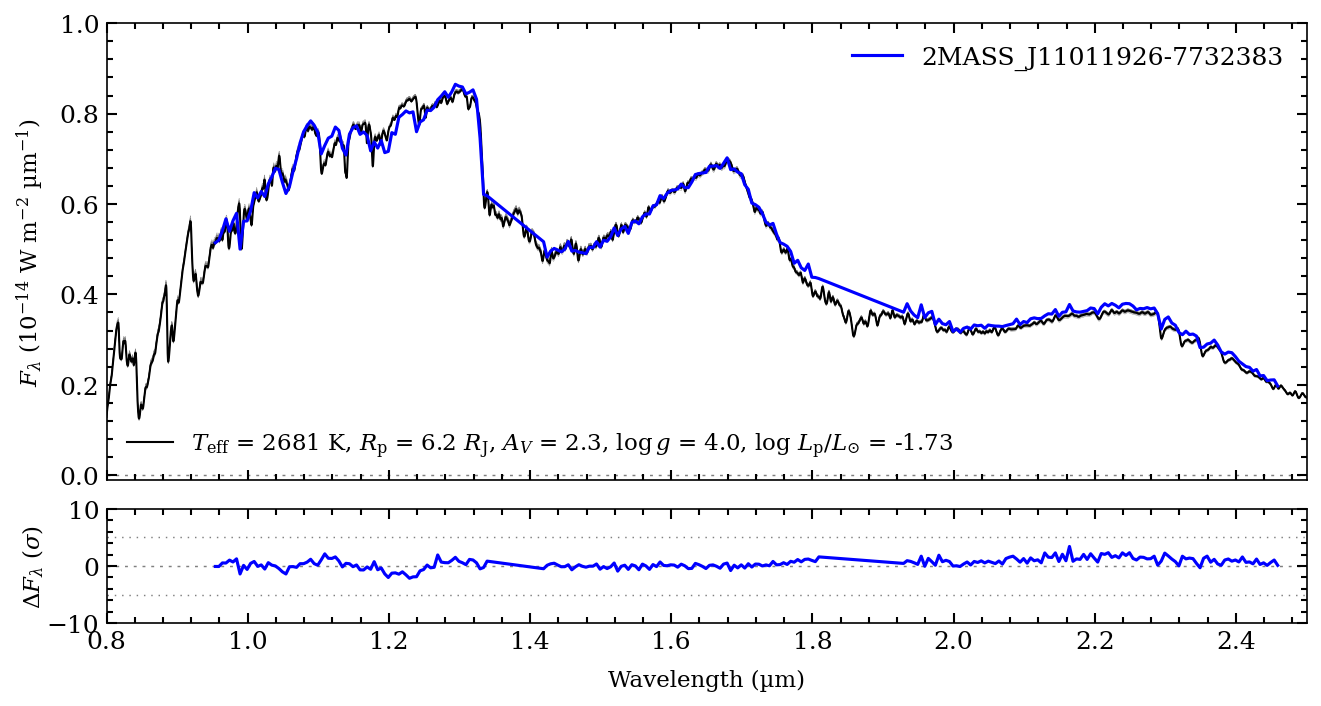

In [19]:
fig = plot_spectrum(boxes=[samples, modelbox, objectbox],
                    filters=objectbox.filters,
                    residuals=residuals,
                    plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                 {'ls': '-', 'lw': 1., 'color': 'black'}, 
                                 {'SOARfull':{'ls':'-', 'color':'blue', 'label':OBJ_NAME}}],
                    xlim=(0.8, 2.5),
                    ylim=(-1.15e-16, 1e-14),
                    ylim_res=(-10., 10.),
                    scale=('linear', 'linear'),
                    offset=(-0.4, -0.05),
                    legend=[{'loc': 'lower left', 'frameon': False, 'fontsize': 11.},
                            {'loc': 'upper right', 'frameon': False, 'fontsize': 12.}],
                    figsize=(8., 4.),
                    quantity='flux density',
                    output=f'{OBJ_NAME}_mcmc_bestfit')

We also determine the median residuals for each band to see if their could be K band excess. 

In [20]:
res_x = residuals.spectrum['SOARfull'][:,0]
res_y = residuals.spectrum['SOARfull'][:,1]
J_res = np.where((res_x>0.95) & (res_x < 1.4))
H_res = np.where((res_x > 1.4)& (res_x < 1.8))
K_res = np.where((res_x > 1.9)& (res_x < 2.5))
JH_res = np.where(((res_x > 0.95)& (res_x < 1.3)) |
    ((res_x > 1.4)& (res_x < 1.8)))
print('continuum residuals for:')
print('J band: ', np.median(res_y[J_res]))
print(' H band: ', np.median(res_y[H_res]))
print(' K band: ', np.median(res_y[K_res]))
print('JH bands: ', np.median(res_y[JH_res]))

continuum residuals for:
J band:  0.15138211753467565
 H band:  0.13536432158231523
 K band:  1.0521573598618796
JH bands:  0.12551080940176704


/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


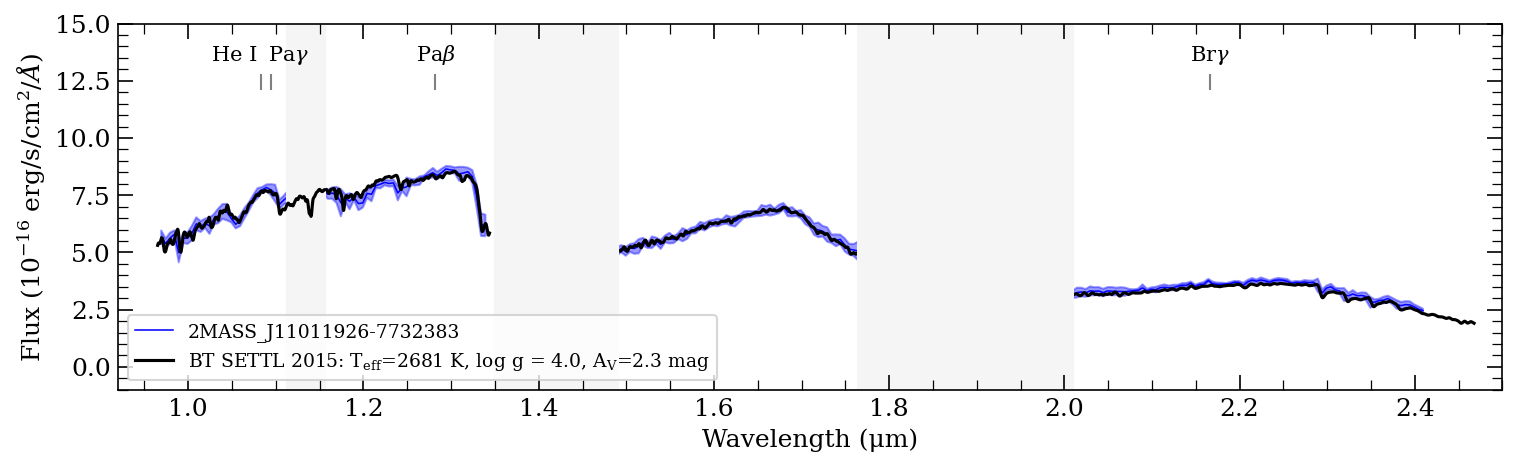

In [21]:

ls=12
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3), dpi=150)

spec = [objectbox, modelbox]
for j in np.arange(2):
    if j == 0:
        Wave = spec[j].spectrum['SOARfull'][0][:,0]
        Flux = spec[j].spectrum['SOARfull'][0][:,1] 
        Error = spec[j].spectrum['SOARfull'][0][:,2] 
        idx = np.where(np.isfinite(Flux))
        Wave = Wave[idx].astype('double')
        Flux = Flux[idx].astype('double')
        Error = Error[idx].astype('double')
    else:
        Wave = spec[j].wavelength
        Flux = spec[j].flux
        idx = np.where(np.isfinite(Flux))
        Wave = Wave[idx].astype('double')
        Flux =Flux[idx].astype('double')
        leg_vals = spec[j].parameters

    idx1 = np.where((Wave >= 0.965) & (Wave < 2.47))
    Wave = Wave[idx1]
    Flux = Flux[idx1]

    IND2 = np.where((Wave >= 1.344)&(Wave <= 1.451))
    Wave[IND2] = np.nan
    Flux[IND2] = np.nan

    IND3 = np.where((Wave >= 1.80)&(Wave <= 1.9624))
    Wave[IND3] = np.nan
    Flux[IND3] = np.nan

    Wave = Wave*u.um
    Flux = (Flux * u.Unit('W/(m2*um)')).to(u.erg / u.s/ u.cm**2/u.AA)

    if j == 0:
        Error = Error[idx1]
        Error[IND2] = np.nan
        Error[IND3] = np.nan
        Error = (Error * u.Unit('W/(m2*um)')).to(u.erg / u.s/ u.cm**2/u.AA)
        ax.plot(Wave[0:-10], Flux[0:-10]/1e-16, color='blue', linewidth=0.75, zorder=-1, label=OBJ_NAME)
        y  = (Flux[0:-10]/1e-16).value
        yerr = (Error[0:-10]/1e-16).value
        ax.fill_between(Wave[0:-10].value, y-yerr, y+yerr, color='blue', 
                        alpha=0.4, zorder=-1)

    else:
        ax.plot(Wave[0:-10], Flux[0:-10]/1e-16, color='k',  zorder=0, 
                label=r'BT SETTL 2015: T$_\mathrm{eff}$=' + f'{int(leg_vals["teff"])} K, log g = {round(leg_vals["logg"],1)}' + r', A$_\mathrm{V}$=' + f'{round(leg_vals["ext_av"],1)} mag')
ax.axvline(1.2822, color='gray', ymin=0.82, ymax=0.86, linewidth=1, linestyle='-')
ax.axvline(1.0941, color='gray', ymin=0.82, ymax=0.86, linewidth=1, linestyle='-')
ax.axvline(2.1661, color='gray', ymin=0.82, ymax=0.86, linewidth=1, linestyle='-')
ax.axvline(1.0833, color='gray', ymin=0.82, ymax=0.86, linewidth=1, linestyle='-')
ax.text(1.2822, 0.9, r'Pa$\beta$', color='k', ha='center', transform=ax.get_xaxis_transform() )
ax.text(1.094+0.02, 0.9, r'Pa$\gamma$', color='k', ha='center', transform=ax.get_xaxis_transform() )
ax.text(2.1655, 0.9, r'Br$\gamma$', color='k', ha='center', transform=ax.get_xaxis_transform() )
ax.text(1.0833-0.03, 0.9, r'He I', color='k', ha='center', transform=ax.get_xaxis_transform() )

ax.tick_params(which='major', direction='in', labelsize=ls, right=True, top=True, length=7)
ax.tick_params(which='minor', direction='in', labelsize=ls, right=True, top=True, length=5)
ax.minorticks_on()

ax.set_xlim(0.92, 2.5)
ax.set_ylim(-1, 15)
ax.set_ylabel(r'Flux (10$^{-16}$ erg/s/cm$^2$/$\AA$)', fontsize=ls)
ax.set_xlabel('Wavelength (μm)', fontsize=ls)

ax.axvspan(1.113, 1.156, color='whitesmoke', alpha=1, zorder=-1)
ax.axvspan(1.35, 1.491, color='whitesmoke', alpha=1, zorder=1)
ax.axvspan(1.764, 2.01, color='whitesmoke', alpha=1, zorder=1)  
ax.legend(loc = 'lower left', fontsize=ls-3)
##############################################

plt.savefig(f'{OBJ_NAME}_bestfitmodel_figure.pdf', dpi=150)
plt.show()

    

## Compute the Errors on the Parameters. 
```species``` MCMC errors are often underestimated and statistical.  Therefore, we want more robust errors that take into account the grid spacing.  We follow the method of Andrews+2013 (see their Fig.15).  

We know from our grid, the temperature is only known to +/- 100 K.  Therefore, using our best fit Temperature, we determine the best fit parameters when Teff+100 and Teff-100.  Then, the errors on each parameter is the distance from the best fit value to the furthest 68% percentile.  

In [22]:
def compute_errors(Teff, plumin):
    database = Database()

    # MUST HAVE PERIOD!
    model = 'bt-settl-cifist'
    spec_res = 500.

    database.add_model(model=model, teff_range=(2100., 3600.))

    if plumin == 'plus':
        Teff_offset = Teff+100
    elif plumin == 'minus':
        Teff_offset = Teff-100
    else:
        Teff_offset = Teff
    
    fit = FitModel(object_name=OBJ_NAME,
                   model=model,
                   bounds={'teff': (Teff_offset, Teff_offset),
                           'radius': (1, 15),
                           'ext_av':(0, 5), 
                          'logg':(4.0, 4.0)},
                   inc_phot=False,
                   inc_spec=['SOAR'],
                   fit_corr=None,
                   apply_weights=False, ext_model='CCM89'
                   ) 
    fit.run_multinest(tag=OBJ_NAME,
                      n_live_points=100,
                      resume=False,
                      output='multinest/',
                      kwargs_multinest=None)

    box = database.get_samples(tag=OBJ_NAME)
    samples = box.samples
    params = box.parameters
 
    teff_index = np.argwhere(np.array(box.parameters) == "teff")[0]
    radius_index = np.argwhere(np.array(box.parameters) == "radius")[0]
    R_JUP = constants.R_jup.value
    L_SUN = constants.L_sun.value
    SIGMA_SB = constants.sigma_sb.value
    lum_atm = (
        4.0
        * np.pi
        * (samples[..., radius_index] * R_JUP) ** 2
        * SIGMA_SB
        * samples[..., teff_index] ** 4.0
        / L_SUN
    )
    
    samples = box.samples[:, 0:3]
    params = box.parameters[0:3]
    ndim = len(params)

    samples = np.append(samples, np.log10(lum_atm), axis=-1)
    params.append("log_lum_atm")
    ndim += 1
    samples0 = samples.reshape((-1, ndim))

    VALS = {}
    VALS['teff'] = [best['teff'], 100]
    for i in np.arange(ndim):
        q_16, q_50, q_84 = corner.quantile(samples0[:, i], [0.16, 0.5, 0.84])

        best_val = best[params[i]]
        if best_val > q_50:
            err = best_val - q_16  
        else:
            err = q_84 - best_val
        VALS[params[i]] = [best_val, err]
        print(params[i], best_val, err)
        
    samples = np.append(np.ones_like(np.log10(lum_atm)), samples, axis=-1)
    params.insert(0, 'teff')
    ndim += 1
    samples = samples.reshape((-1, ndim))   
    
    return samples, VALS


In [23]:
Teff = modelbox.parameters["teff"]
plus_samples, plus_vals = compute_errors(Teff, plumin = 'plus')



-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 95/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.
 3300. 3400. 3500. 3600.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 16
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 96
Number of interpolated grid points: 1
Number of missing grid points: 0

-----------------
Fit model spectra
-----------------

Object name: 2MASS_J11011926-7732383
Model tag: bt-settl-cifist
Binary star: Fals

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/util/data_util.py:413: RuntimeWarning: divide by zero encountered in log10
  flux = np.log10(flux)


 [DONE]

Fixing 2 parameters:
   - teff = 2781.1886825064225
   - logg = 4.0

Fitting 3 parameters:
   - radius
   - parallax
   - ext_av

Uniform priors (min, max):
   - radius = (1, 15)
   - ext_av = (0, 5)

Normal priors (mean, sigma):
   - parallax = 5.36 +/- 0.15

Weights for the log-likelihood function:
   - SOAR = 1.00

------------------------------
Nested sampling with MultiNest
------------------------------

Database tag: 2MASS_J11011926-7732383
Number of live points: 100
Resume previous fit: False
Output folder: multinest/

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  100
 dimensionality =    3
 *****************************************************
 ln(ev)=   5426.0911399901233      +/-  0.31292532075494295     
 Total Likelihood Evaluations:         2217
 Sampling finished. Exiting MultiNest

log-evidence = 5426.09 +/- 0.31
log-evidence (importance sampling) = 5425.63

In [24]:
minus_samples, minus_vals = compute_errors(Teff, plumin = 'minus')


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 95/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.
 3300. 3400. 3500. 3600.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 16
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 96
Number of interpolated grid points: 1
Number of missing grid points: 0

-----------------
Fit model spectra
-----------------

Object name: 2MASS_J11011926-7732383
Model tag: bt-settl-cifist
Binary star: Fals

2681.1886825064225


/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/var/folders/hv/sqhlym89251brwhx_6w2mmrc0005n_/T/ipykernel_64760/3441677371.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/var/folders/hv/sqhlym89251brwhx_6w2mmrc0005n_/T/ipykernel_64760/3441677371.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


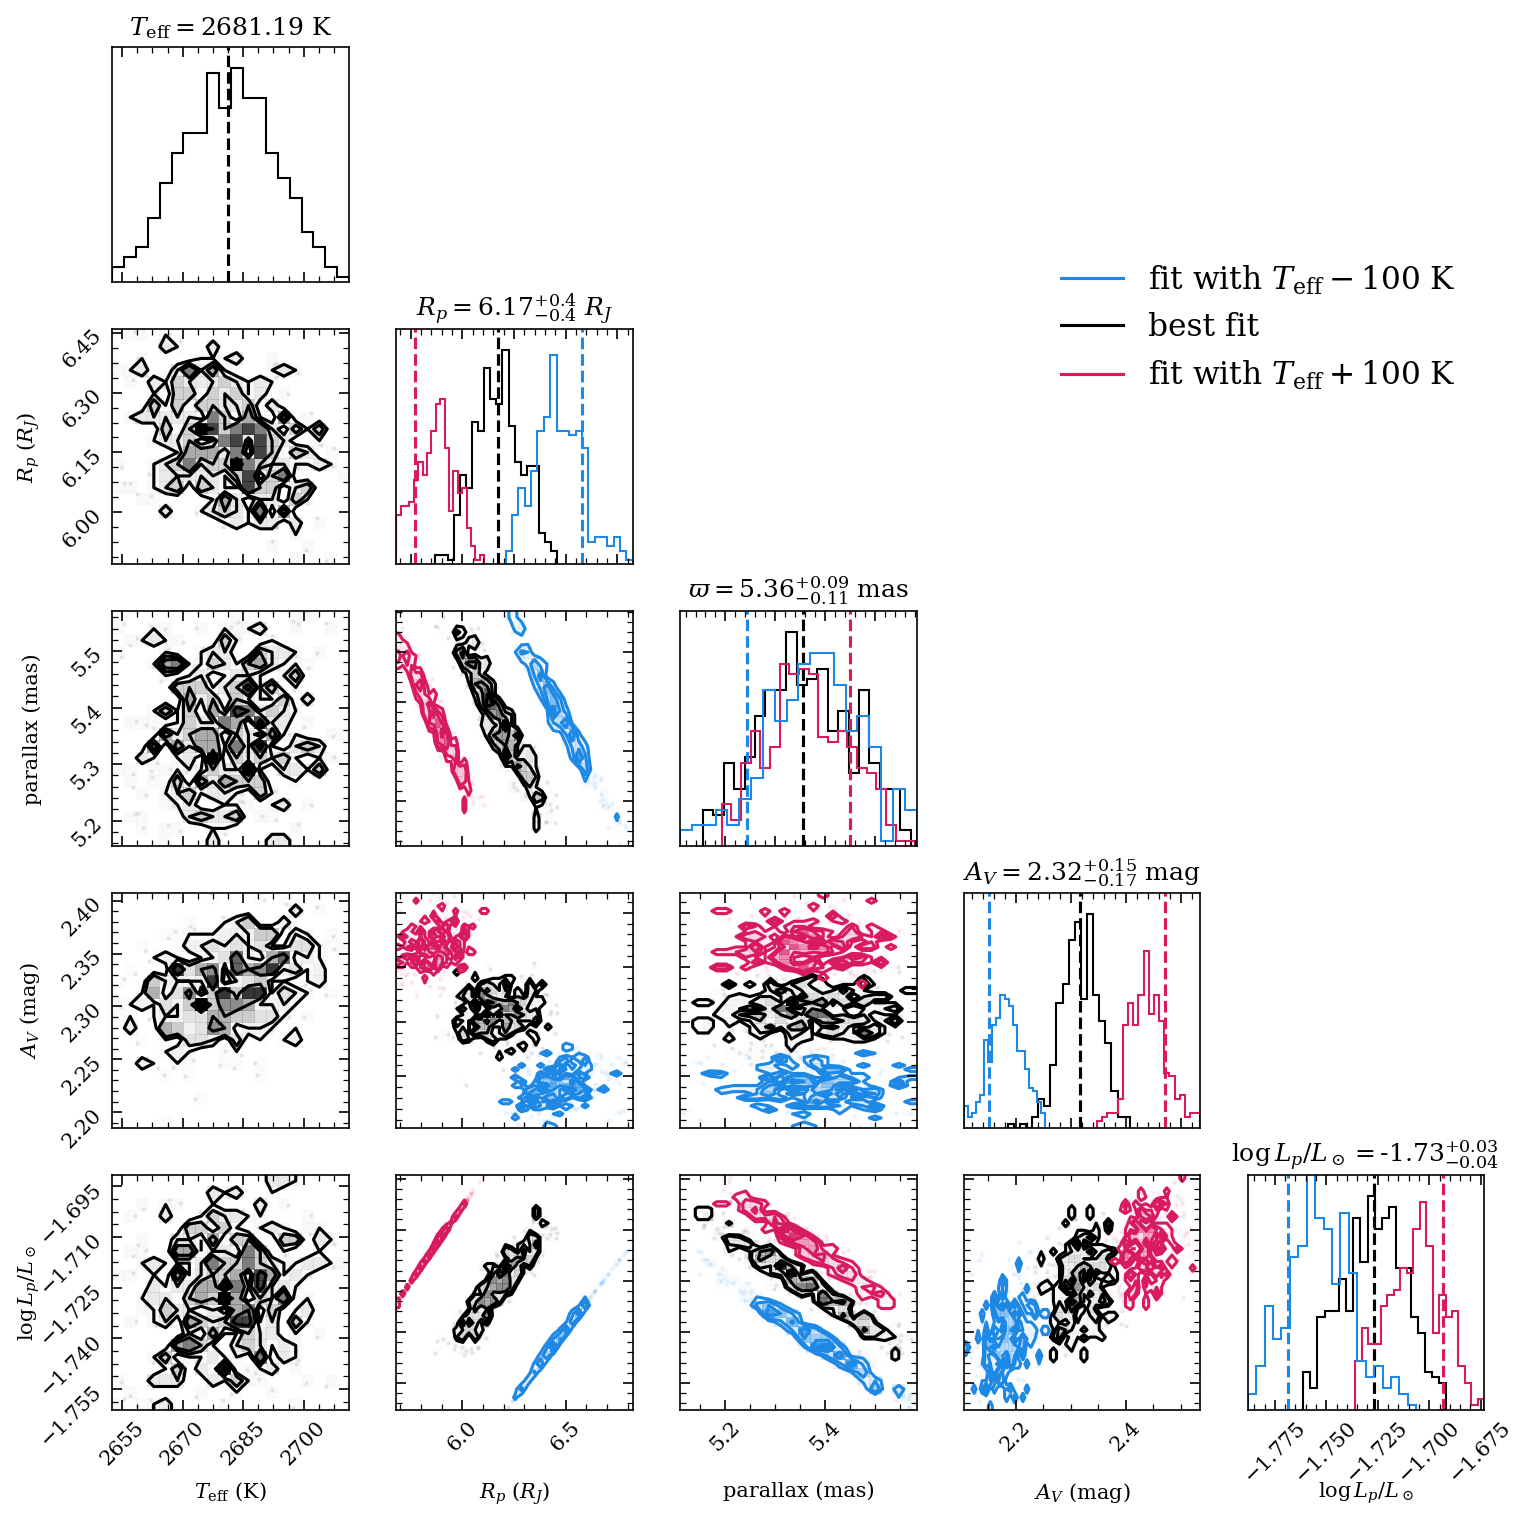

In [25]:
print(Teff)

red = '#D81B60'
blue = '#1E88E5'
labels=[r"$T_{\rm eff}$ (K)", r"$R_p\ (R_J)$", r"parallax (mas)", r"$A_V$ (mag)", r"$\log L_p / L_\odot$"]
figure = corner.corner(best_samples, labels=labels, quantiles=[0.5])

axes = np.array(figure.axes).reshape((5, 5))
labels=[r"$T_{\rm eff}$", r"$R_p$", r"$\varpi$", r"$A_V$", r"$\log L_p / L_\odot$"]
labelend = ["K", r"$R_J$", "mas", "mag", ""]
for i, k in enumerate(list(plus_vals.keys())):
    ax = axes[i, i]
    if i > 0:
        ax.set_title(labels[i] + '$=$' + str(round(plus_vals[k][0],2)) + '$^{+' + str(round(plus_vals[k][1],2)) + '}_{-' + str(round(minus_vals[k][1],2)) + '}$ ' + labelend[i])
        if k == 'radius':
            ax.axvline(plus_vals[k][0]-plus_vals[k][1], color=red, linestyle='--')
            ax.axvline(plus_vals[k][0]+minus_vals[k][1], color=blue, linestyle='--')
        else:
            ax.axvline(plus_vals[k][0]+plus_vals[k][1], color=red, linestyle='--')
            ax.axvline(plus_vals[k][0]-minus_vals[k][1], color=blue, linestyle='--')
       

        ax.hist(plus_samples[:,i], bins=20, color=red, histtype='step')
        ax.hist(minus_samples[:,i], bins=20, color=blue, histtype='step')
        minn = min(min(plus_samples[:,i]), min(minus_samples[:,i]))
        maxx = max(max(plus_samples[:,i]), max(minus_samples[:,i]))
        ax.set_xlim(minn, maxx)
    else:
        ax.set_title(labels[i] + '$=$' + str(round(plus_vals[k][0],2)) + ' ' + labelend[i])


for yi in np.arange(5):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        if (yi > 0) & (xi>0):
            ax = axes[yi, xi]
            corner.hist2d(plus_samples[:, xi],plus_samples[:, yi], ax=ax, color=red)
            corner.hist2d(minus_samples[:, xi],minus_samples[:, yi], ax=ax, color=blue)
            minn = min(min(plus_samples[:,xi]), min(minus_samples[:,xi]))
            maxx = max(max(plus_samples[:,xi]), max(minus_samples[:,xi]))
            ax.set_xlim(minn, maxx)
            
            minn = min(min(plus_samples[:,yi]), min(minus_samples[:,yi]))
            maxx = max(max(plus_samples[:,yi]), max(minus_samples[:,yi]))
            ax.set_ylim(minn, maxx)
        if (xi > 0):  
            ax.set_yticklabels([])
        if yi <4:
            ax.set_xticklabels([])

labels= [r'fit with $T_{\rm eff} - 100$ K', 'best fit', r'fit with $T_{\rm eff} + 100$ K']
colors = [blue, 'k', red]
plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=labels[i])
            for i in np.arange(3)
        ],
        fontsize=15, frameon=False,
        bbox_to_anchor=(1, 5), loc="upper right"
    )

plt.tight_layout()
plt.savefig(f'{OBJ_NAME}_posterior.pdf', dpi=150)
plt.show()

## Finally, we save our best fit model and best fit parameters 

In [26]:


Wave = modelbox.wavelength
Flux = modelbox.flux
idx = np.where(np.isfinite(Flux))
Wave = Wave[idx].astype('double')
Flux =Flux[idx].astype('double')
            
final_model = np.c_[Wave, Flux]
leg_vals = modelbox.parameters
print('saving best fit model to: ', f'{OBJ_NAME}_BTSettl_bestfit_spectra_T{int(leg_vals["teff"])}_logg{round(leg_vals["logg"],1)}_Av{round(leg_vals["ext_av"],1)}.txt')

np.savetxt(f'{OBJ_NAME}_BTSettl_T{int(leg_vals["teff"])}_logg{round(leg_vals["logg"],1)}_Av{round(leg_vals["ext_av"],1)}.txt', final_model)




saving best fit model to:  2MASS_J11011926-7732383_BTSettl_bestfit_spectra_T2681_logg4.0_Av2.3.txt


In [27]:
name = []
value = []
minn = []
maxx = []

for key, val in plus_vals.items():
    if key != 'parallax':
        name.append(key)
        value.append(val[0])
        minn.append(minus_vals[key][1])
        maxx.append(val[1])
d = {'name': name, 'best_fit': value, 'err_lo':minn, 'err_hi':maxx}
df = pd.DataFrame(d)
print('save best fit parameters to: ', f'{OBJ_NAME}_BTSettl_bestfit_parameters.csv')
df.to_csv(f'{OBJ_NAME}_BTSettl_bestfit_parameters.csv')            



save best fit parameters to:  2MASS_J11011926-7732383_BTSettl_bestfit_parameters.csv
